In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Import the libraries
import math
#import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [5]:
import numpy as np
import tensorflow as tf
tf.random.set_seed(4)
np.random.seed(4)

In [6]:
# Loading Data

cols=['Timestamp','Memory_Allocated','Memory_Used','CPU_Allocated','CPU_Used','Network_Bandwidth_Utilization','Storage_Space_Utilization',
      'Group_ID','Instance']

df = pd.read_csv("/content/drive/My Drive/REVA/Interview/inputData.csv", sep=',', 
                   header=1, 
                   names=cols, 
                   engine="python",
                   encoding="latin1")

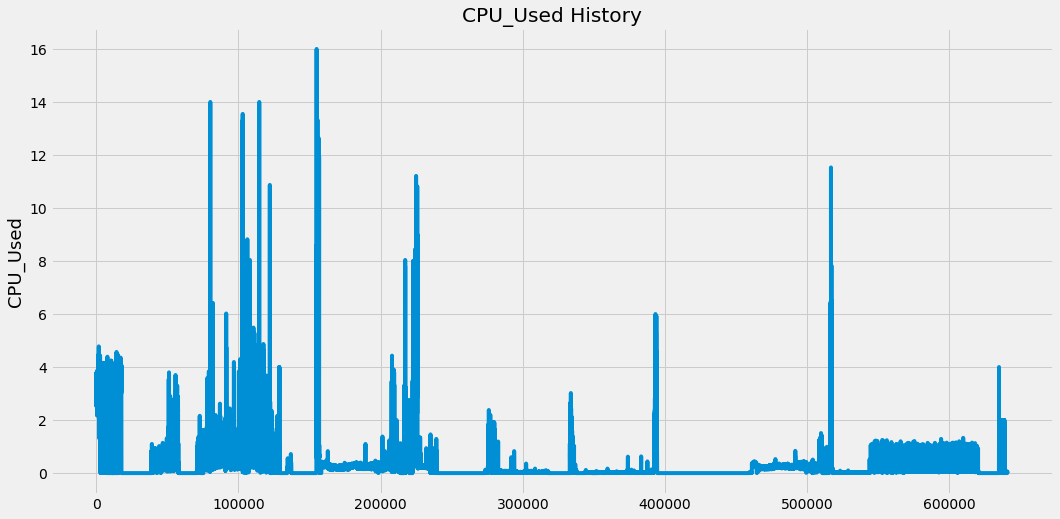

In [46]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('CPU_Used History')
plt.plot(df['CPU_Used'])
plt.ylabel('CPU_Used',fontsize=18)
plt.show()

In [10]:
df1=df.reset_index()['CPU_Used']

In [11]:
df1.shape

(640883,)

In [12]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler

In [13]:
import numpy as np

In [14]:
df1

0         3.24
1         2.69
2         3.26
3         2.72
4         3.27
          ... 
640878    0.01
640879    0.01
640880    0.01
640881    0.01
640882    0.01
Name: CPU_Used, Length: 640883, dtype: float64

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [16]:
print(df1)

[[0.2025  ]
 [0.168125]
 [0.20375 ]
 ...
 [0.000625]
 [0.000625]
 [0.000625]]


In [17]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [18]:
training_size,test_size

(416573, 224310)

In [19]:
train_data

array([[0.2025  ],
       [0.168125],
       [0.20375 ],
       ...,
       [0.      ],
       [0.      ],
       [0.      ]])

In [20]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [21]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [22]:
print(X_train)

[[0.2025   0.168125 0.20375  ... 0.201875 0.17375  0.2125  ]
 [0.168125 0.20375  0.17     ... 0.17375  0.2125   0.20875 ]
 [0.20375  0.17     0.204375 ... 0.2125   0.20875  0.170625]
 ...
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]]


In [23]:
print(X_train.shape), print(y_train.shape)

(416472, 100)
(416472,)


(None, None)

In [24]:
print(X_test.shape), print(ytest.shape)

(224209, 100)
(224209,)


(None, None)

In [25]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [26]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [27]:
def fit_lstm(X_train, test, raw, scaler, batch_size, nb_epoch, neurons):
	X, y = X_train[:, 0:-1], X_train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# prepare model
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit model
	X_train_rmse, test_rmse = list(), list()
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
		# evaluate model on train data
		raw_X_train = raw[-(len(train)+len(test)+1):-len(test)]
		train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
		model.reset_states()
		# evaluate model on test data
		raw_test = raw[-(len(test)+1):]
		test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
		model.reset_states()
	history = DataFrame()
	history['X_train'], history['test'] = X_train_rmse, test_rmse
	return history

In [28]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=20,batch_size=64,verbose=1)

Epoch 1/20
6508/6508 [==============================] - 116s 18ms/step - loss: 1.7412e-04 - accuracy: 0.3445 - val_loss: 3.0854e-05 - val_accuracy: 0.2667
Epoch 2/20
6508/6508 [==============================] - 117s 18ms/step - loss: 1.5764e-04 - accuracy: 0.3445 - val_loss: 2.2859e-05 - val_accuracy: 0.2667
Epoch 3/20
6508/6508 [==============================] - 116s 18ms/step - loss: 1.5434e-04 - accuracy: 0.3445 - val_loss: 2.1937e-05 - val_accuracy: 0.2667
Epoch 4/20
6508/6508 [==============================] - 117s 18ms/step - loss: 1.5256e-04 - accuracy: 0.3445 - val_loss: 2.2243e-05 - val_accuracy: 0.2667
Epoch 5/20
6508/6508 [==============================] - 117s 18ms/step - loss: 1.5131e-04 - accuracy: 0.3445 - val_loss: 2.8722e-05 - val_accuracy: 0.2667
Epoch 6/20
6508/6508 [==============================] - 117s 18ms/step - loss: 1.5041e-04 - accuracy: 0.3445 - val_loss: 2.1969e-05 - val_accuracy: 0.2667
Epoch 7/20
6508/6508 [==============================] - 115s 18ms/step

In [31]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


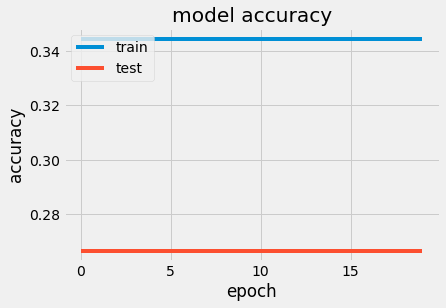

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

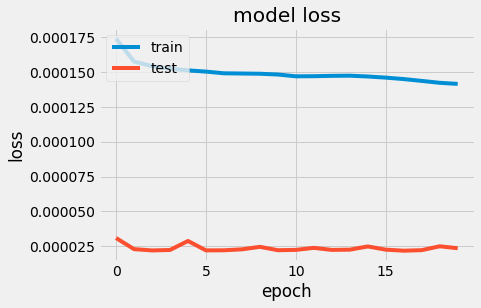

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
import tensorflow as tf

In [35]:
tf.__version__

'2.3.0'

In [36]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [37]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [38]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.7554555299738976

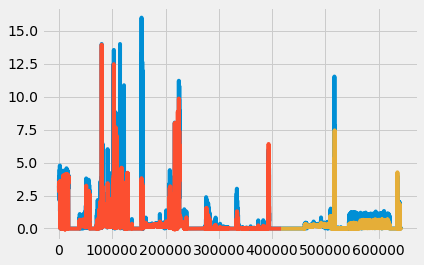

In [39]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [40]:
len(test_data)

224310

In [41]:
test_data.shape

(224310, 1)

In [42]:
x_input=test_data[854:].reshape(1,-1)
x_input.shape

(1, 223456)